# Numerical demonstration of "Fock lasing" effect in systems with sharply nonlinear loss

The purpose of this notebook is to demonstrate numerically (from solutions of the Liouvillian equation) that a gain medium, coupled to the nonlinear coupled-resonator system (the latter evolving according to Eq. (8) of the SI), lases into a heavily sub-Poissonian state, approaching a Fock state. It is effectively impossible to model from quantum mechanical first principles the interaction of $N$ pumped atoms with a cavity (because the Hilbert space dimension of $N \gg 1$ atoms is simply too large). Instead, we will look at the coupling of one single pumped four-level system interacting with the cavity, and look at the photon probability distribution in the steady state. 

Such a system, a single emitter coupled to a cavity (with a suitably rescaled coupling), is capable of correctly modeling the quantum dynamics of a laser, because in a laser, there are negligible inter-atom correlations. The type of model considered here also has a physical "life of its own" as experiments exist demonstrating "one-atom lasing / masing" in which a single pumped atom is sufficient to exceed the threshold of the system (due to its very low losses). Such one atom lasers have been developed at both optical and microwave frequencies (the latter with superconducting qubits).

We note that the descriptions and discussion provided in this notebook are largely similar to the discussion in the relevant section of the Supplementary Information.

In [57]:
## Load packages and set some fonts for the plots.

using LinearAlgebra
using DifferentialEquations
using QuantumOptics
using Distributions
using SparseArrays
using Arpack
using PyPlot
using ForwardDiff
using DelimitedFiles

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 12;
rcParams["font.sans-serif"] = "Arial";

In [58]:
function stats(nvals,dist)
    
    n2vals = nvals.^2;
    nexp = sum(nvals.*dist);
    n2exp = sum(n2vals.*dist);
    dn = sqrt(n2exp-nexp^2);
    fano = dn^2/nexp;
    
    return nexp, dn, fano;
end

function loss(wa,wd,κ,γ,λ)
    δ = wa - wd;
    Lw = (κ*δ^2 + γ*abs(λ)^2 + 2*sqrt(κ*γ)*δ*real(λ)) / (δ^2 + γ^2 / 4);
    return Lw
end

function ωn(wa, β, n)
    wn = wa*(1+2*β*n);
    return wn
end

ωn (generic function with 1 method)

The cell below follows the standard procedure in QuantumOptics.jl: set up a Hilbert space of the system, as well as operators. First, we define the parameters of the nonlinear cavity + four-level system. 

For the cavity, let's consider a system that evolves according to the master equation, Eq. (8) of the SI. We need to specify the frequencies of the $a$ and $d$ resonances, as well as the nonlinearity $\beta$, the coupling $\lambda$, and the decay rates $\kappa$ and $\lambda$. These parameters specify the temporal loss coefficient $\kappa(n) = L(n)/n$ shown in Eq. (24) of the SI. The parameters here for the nonlinear cavity are the same as those used in the notebook entitled "Transient noise condensation".

In [18]:
ωc = 1.0;
δ = -30e-3
ωd = 1 + δ;

β = -5e-4;
κ = 1e-7;
γ = 1e-2;
λ = 0;

nvals = [0:1:110;]
Ln = real([loss(ωn(ωc, β, nn),ωd,κ,γ,λ) for nn in nvals]);

For the gain, we consider a four-level system with a similar pumping and decay structure to something like a solid-state gain medium: the upper pump level (4) and the lower lasing level (2) decay very rapidly compared to all timescales in the problem. The lasing transition 2-3 has some fast polarization decay time $\gamma_{T}$ and a population decay time $\gamma_{L}$. The lower pump level (the ground level, 1) is connected to the upper pump level by a pump rate $\gamma_{41}$.

In [19]:
# Four-level system parameters

ωa = 1.0;

E1 = 0; # Can take as zero without loss of generality.
E2 = 1.2; # Specific value here plays no role, only energy difference between second and third levels 
E3 = E2 + ωa;
E4 = 3; # Specific value plays no role.

Λ = 3.4e-6#2.6e-6; # Pump rate
γT = 1e-2; # Polarization decay rate
γL = 1e-4; # Population decay rate
γ34 = 1; # Decay from upper pump level to upper lasing level
γ13 = 0; # Decay from upper lasing level to lower pump level / ground state
γ12 = 1e-3; # Decay from lower lasing level to lower pump level / ground state

g = 3e-4 # Coupling of atom to photon. Should be scaled to emulate effect of more than one atom.
Rsp = 2*g^2 / (γT + γ12);
ns = γL / Rsp;

Gn = 0.5*[Λ*Rsp/(γL + Rsp*(nn)) for nn in nvals]; # Only valid in non-depleted pump approximation.

println("The spontaneous emission rate is $(Rsp).")
println("The expected inversion is $((Λ/γL)).")
println("The ratio of polarization decay to lower-lasing decay is $((γT/γ12)) [should be >> 1].")
println("The ratio of lower lasing decay to spontaneous emission is $((γ12/Rsp)) [should be >> 1].")
println("The ratio of relaxation to spontaneous emission is $(γL/Rsp) [should be > 1 if decay is radiative].")
println("The saturation photon number is $(ns).")

The spontaneous emission rate is 1.6363636363636363e-5.
The expected inversion is 0.033999999999999996.
The ratio of polarization decay to lower-lasing decay is 10.0 [should be >> 1].
The ratio of lower lasing decay to spontaneous emission is 61.111111111111114 [should be >> 1].
The ratio of relaxation to spontaneous emission is 6.111111111111112 [should be > 1 if decay is radiative].
The saturation photon number is 6.111111111111112.


Let us plot a gain/loss curve similar to the ones employed in the main text. This will line-up well with the different regimes of operation (sub-threshold, bistable, near-Fock). Note that the agreement with the analytical theory of the SI is imperfect because at these low photon numbers, spontaneous emission affects the threshold. Nevertheless, the effects shown in the manuscript are all (clearly) present below (especially the very low-noise steady-states.)

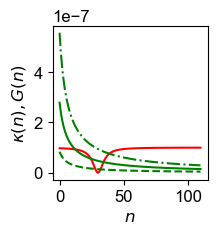

In [20]:
figure(figsize=(2,2));
plot(nvals,Ln,linestyle="-",color="red")
plot(nvals,0.3*Gn,linestyle="--",color="green")
plot(nvals,Gn,linestyle="-",color="green")
plot(nvals,2*Gn,linestyle="-.",color="green")
xlabel(L"n")
ylabel(L"κ(n),G(n)")
savefig("gl_curves_numerical_fock_lasing.svg",format="svg")

Now let us set up the Hilbert space, Hamiltonian, and Liouvillian. Then, we find the steady state of the Liouvillian and calculate the photon probability distribution (as well as the atomic distribution, and the distribution in the $d$ mode). We will compute the lowest two eigenvalues (two to check for bistability) and corresponding eigenvectors. In cases where there is only one clearly numerically zero eigenvalue, we just plot the unique steady-state (in the example below, there is one steady-state).

In [21]:
## Setting up Hilbert space and operators

N_cutoff = 70;
N_d = 1;
N_gain = 4;

nvals_a = [0:1:N_cutoff;];
nvals_d = [0:1:N_d;];

b_fock = FockBasis(N_cutoff);
b_d = FockBasis(N_d);
b_atom = NLevelBasis(N_gain);

b = b_fock ⊗ b_d ⊗ b_atom;

## Operators for a

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

## Operators for d

d = destroy(b_d);
dd = create(b_d);
nd = number(b_d);
Id = identityoperator(b_d);

X = (sqrt(Complex(κ/(κ+γ)))*(a ⊗ Id) + sqrt(Complex(γ/(κ+γ)))*(Ip ⊗ d))
Xd = dagger(X);

## Operators for four-level system (transition(j,i) goes from i to j)

σ41 = transition(b_atom, 4, 1);
σ34 = transition(b_atom, 3, 4);
σ23 = transition(b_atom, 2, 3);
σ32 = transition(b_atom, 3, 2);
σ31 = transition(b_atom, 3, 1);
σ13 = transition(b_atom, 1, 3);
σ12 = transition(b_atom, 1, 2);

σ11 = transition(b_atom, 1, 1);
σ22 = transition(b_atom, 2, 2);
σ33 = transition(b_atom, 3, 3);
σ44 = transition(b_atom, 4, 4);
σz = σ33 - σ22;

Ie = identityoperator(b_atom);

## Setting up Hamiltonian + Lindblad terms (no gain) 

H_nl =  ωc*n + ωc*β*ad*ad*a*a;
H_at = E1*σ11 + E2*σ22 + E3*σ33 + E4*σ44;
H_rwa =  H_nl ⊗ Id ⊗ Ie +  ωd*(Ip ⊗ nd ⊗ Ie) + (λ*a ⊗ dd + conj(λ)*ad ⊗ d) ⊗ Ie + Ip ⊗ Id ⊗ H_at + 
         g*(a ⊗ Id ⊗ σ32 + ad ⊗ Id ⊗ σ23);

jump_γ = sqrt(κ+γ)*(X ⊗ Ie);
jump_12 = identityoperator(b_fock ⊗ b_d) ⊗ σ12;
jump_T = identityoperator(b_fock ⊗ b_d) ⊗ σz;
jump_L = identityoperator(b_fock ⊗ b_d) ⊗ σ23;
jump_34 = identityoperator(b_fock ⊗ b_d) ⊗ σ34;
jump_Λ = identityoperator(b_fock ⊗ b_d) ⊗ σ41;
jumps = [jump_γ, jump_12, jump_T, jump_L, jump_34, jump_Λ];
rates = [1, γ12, γT, γL, γ34, Λ];

liouville_op = liouvillian(H_rwa, jumps; rates=rates);
liouville_mat = sparse(liouville_op).data;
@elapsed minval = eigs(liouville_mat,nev = 2, which=:SM)

kk = 1;
ρss = abs.(reshape(minval[2][:,kk],((N_cutoff+1)*(N_d+1)*N_gain,(N_cutoff+1)*(N_d+1)*N_gain)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b,ρss);

ρ_ph_ad = ptrace(ρ_op,3);
ρ_ph_a = ptrace(ρ_op,[2,3]);
ρ_ph_d = ptrace(ρ_op,[1,3]);
ρ_at = ptrace(ρ_op,[1,2]);

Below, we plot the partial trace of the corresponding eigenvector to get the photon probability distribution. We also examine the atomic population distribution and the population of the $d$ mode. As you will see below:
- The laser steady state has noise 90% below the coherent-state limit (and much below what standard nonlinear absorbers and low-order nonlinearities provide). The photon uncertainty is about 1.9. The photon number is 35, which is near the approximate zero of the loss at 30 (it is higher for reasons that are evident for the gain-loss curves).
- The atomic populations are what you expect from a canonical four-level gain: the lowest level is negligibly depleted, the lower lasing and upper pump levels have negligible population, and the small population in the upper lasing level is enough for inversion.
- The $d$ mode has very little photons in it, as expected from $\gamma \gg \kappa$.

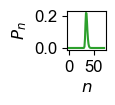

In [22]:
figure(figsize=(0.5,0.5));
plot(diag(ρ_ph_a.data),linestyle="-",color="C2")
xlabel(L"n")
ylabel(L"P_n")
stats(nvals_a,diag(ρ_ph_a.data))
savefig("low_noise_numerical_fock_lasing.svg",format="svg")

In [23]:
diag(ρ_at.data)

4-element Array{Complex{Float64},1}:
    0.9768161060825691 + 0.0im
 0.0033211747606807325 + 0.0im
   0.01985939798198903 + 0.0im
 3.3211747606823676e-6 + 0.0im

In [24]:
diag(ρ_ph_d.data)

2-element Array{Complex{Float64},1}:
     0.999783483542662 + 0.0im
 0.0002165164573372897 + 0.0im

The cells above were for a single set of gain parameters. Now, let us plot the photon number and statistical properties of $a$ as a function of the pump rate $\Lambda$.

In [10]:
pump_vals = [0.2:0.05:5;]*1e-6
nexp_vals = zeros(length(pump_vals));
dn2_vals = zeros(length(pump_vals));
fano_vals = zeros(length(pump_vals));

for ii = 1:length(pump_vals)
    
    Λ = pump_vals[ii];
    rates = [1, γ12, γT, γL, γ34, Λ];

    liouville_op = liouvillian(H_rwa, jumps; rates=rates);
    liouville_mat = sparse(liouville_op).data;
    @elapsed minval = eigs(liouville_mat,nev = 2, which=:SM)

    kk = 1;
    ρss = abs.(reshape(minval[2][:,kk],((N_cutoff+1)*(N_d+1)*N_gain,(N_cutoff+1)*(N_d+1)*N_gain)))
    ρss = ρss/tr(ρss);
    ρ_op = DenseOperator(b,ρss);
    ρ_ph_ad = ptrace(ρ_op,3);
    ρ_ph_a = ptrace(ρ_op,[2,3]);
    ρ_ph_d = ptrace(ρ_op,[1,3]);
    ρ_at = ptrace(ρ_op,[1,2]);
    
    nexp, dn, fano = real.(stats(nvals_a,diag(ρ_ph_a.data)));
    nexp_vals[ii] = nexp;
    dn2_vals[ii] = dn^2;
    fano_vals[ii] = fano;
    
end

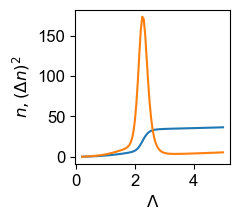

In [11]:
figure(figsize=(2,2));
plot(pump_vals*1e6,nexp_vals)
plot(pump_vals*1e6,dn2_vals)
xlabel(L"\Lambda")
ylabel(L"n,(\Delta n)^2")
savefig("s_curve_numerical_fock_lasing.svg",format="svg")

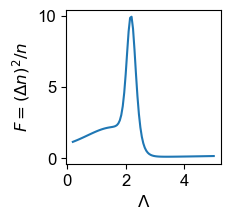

In [12]:
figure(figsize=(2,2));
plot(pump_vals*1e6,fano_vals)
xlabel(L"\Lambda")
ylabel(L"F = (\Delta n)^2 / n")
savefig("fano_numerical_fock_lasing.svg",format="svg")

Feel free to change parameters of the loss with respect to the "Transient noise condensation" notebook to find situations with even better noise reduction in the steady state. This example shows one in which a very high-order sub-Poissonian state can be created. The state below has nearly 95% less noise than the shot noise level, with about 160 photons (this also goes beyond the maximum noise reduction theoretically possible from squeezing + coherent-displacement, and could still be improved).

In [53]:
## Setting up Hilbert space and operators

ωc = 1.0;
δ = -60e-3
ωd = 1 + δ;

β = -0.4*5e-4;
κ = 1e-7;
γ = 1e-2;
λ = 0;

ωa = 1.0;

E1 = 0; # Can take as zero without loss of generality.
E2 = 1.2; # Specific value here plays no role, only energy difference between second and third levels 
E3 = E2 + ωa;
E4 = 3; # Specific value plays no role.

Λ = 5*3.4e-6#2.6e-6; # Pump rate
γT = 1e-2; # Polarization decay rate
γL = 1e-4; # Population decay rate
γ34 = 1; # Decay from upper pump level to upper lasing level
γ13 = 0; # Decay from upper lasing level to lower pump level / ground state
γ12 = 1e-3; # Decay from lower lasing level to lower pump level / ground state

g = 3e-4 # Coupling of atom to photon. Should be scaled to emulate effect of more than one atom.
Rsp = 2*g^2 / (γT + γ12);
ns = γL / Rsp;

N_cutoff = 250;
N_d = 1;
N_gain = 4;

nvals_a = [0:1:N_cutoff;];
nvals_d = [0:1:N_d;];

b_fock = FockBasis(N_cutoff);
b_d = FockBasis(N_d);
b_atom = NLevelBasis(N_gain);

b = b_fock ⊗ b_d ⊗ b_atom;

## Operators for a

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

## Operators for d

d = destroy(b_d);
dd = create(b_d);
nd = number(b_d);
Id = identityoperator(b_d);

X = (sqrt(Complex(κ/(κ+γ)))*(a ⊗ Id) + sqrt(Complex(γ/(κ+γ)))*(Ip ⊗ d))
Xd = dagger(X);

## Operators for four-level system (transition(j,i) goes from i to j)

σ41 = transition(b_atom, 4, 1);
σ34 = transition(b_atom, 3, 4);
σ23 = transition(b_atom, 2, 3);
σ32 = transition(b_atom, 3, 2);
σ31 = transition(b_atom, 3, 1);
σ13 = transition(b_atom, 1, 3);
σ12 = transition(b_atom, 1, 2);

σ11 = transition(b_atom, 1, 1);
σ22 = transition(b_atom, 2, 2);
σ33 = transition(b_atom, 3, 3);
σ44 = transition(b_atom, 4, 4);
σz = σ33 - σ22;

Ie = identityoperator(b_atom);

## Setting up Hamiltonian + Lindblad terms (no gain) 

H_nl =  ωc*n + ωc*β*ad*ad*a*a;
H_at = E1*σ11 + E2*σ22 + E3*σ33 + E4*σ44;
H_rwa =  H_nl ⊗ Id ⊗ Ie +  ωd*(Ip ⊗ nd ⊗ Ie) + (λ*a ⊗ dd + conj(λ)*ad ⊗ d) ⊗ Ie + Ip ⊗ Id ⊗ H_at + 
         g*(a ⊗ Id ⊗ σ32 + ad ⊗ Id ⊗ σ23);

jump_γ = sqrt(κ+γ)*(X ⊗ Ie);
jump_12 = identityoperator(b_fock ⊗ b_d) ⊗ σ12;
jump_T = identityoperator(b_fock ⊗ b_d) ⊗ σz;
jump_L = identityoperator(b_fock ⊗ b_d) ⊗ σ23;
jump_34 = identityoperator(b_fock ⊗ b_d) ⊗ σ34;
jump_Λ = identityoperator(b_fock ⊗ b_d) ⊗ σ41;
jumps = [jump_γ, jump_12, jump_T, jump_L, jump_34, jump_Λ];
rates = [1, γ12, γT, γL, γ34, Λ];

liouville_op = liouvillian(H_rwa, jumps; rates=rates);
liouville_mat = sparse(liouville_op).data;
@elapsed minval = eigs(liouville_mat,nev = 2, which=:SM)

61.724053527

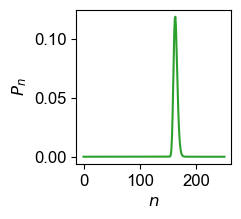

(163.33417785958332 + 0.0im, 3.4077016476524857 + 0.0im, 0.07109614577664543 + 0.0im)

In [54]:
kk = 1;
ρss = abs.(reshape(minval[2][:,kk],((N_cutoff+1)*(N_d+1)*N_gain,(N_cutoff+1)*(N_d+1)*N_gain)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b,ρss);

ρ_ph_ad = ptrace(ρ_op,3);
ρ_ph_a = ptrace(ρ_op,[2,3]);
ρ_ph_d = ptrace(ρ_op,[1,3]);
ρ_at = ptrace(ρ_op,[1,2]);

figure(figsize=(2,2));
plot(diag(ρ_ph_a.data),linestyle="-",color="C2")
xlabel(L"n")
ylabel(L"P_n")
stats(nvals_a,diag(ρ_ph_a.data))

The physics extends to even larger photon numbers. By reducing the strength of the nonlinearity, the location of the approximate zero of the loss gets pushed to higher photon numbers. This next example shows that the same very high noise reduction is obtained when the nonlinearity is reduced by a factor of three, such that the low-noise state, with ~95% less noise than shot noise (over all frequencies!) has 500 photons.

This also shows that the concept does not get fundamentally harder to realize with higher photon numbers.

In [80]:
## Setting up Hilbert space and operators

ωc = 1.0;
δ = -1*60e-3
ωd = 1 + δ;

β = -(1/3)*0.4*5e-4;
κ = 1e-7;
γ = 1e-2;
λ = 0;

ωa = 1.0;

E1 = 0; # Can take as zero without loss of generality.
E2 = 1.2; # Specific value here plays no role, only energy difference between second and third levels 
E3 = E2 + ωa;
E4 = 3; # Specific value plays no role.

Λ = 12*3.4e-6#2.6e-6; # Pump rate
γT = 1e-2; # Polarization decay rate
γL = 1e-4; # Population decay rate
γ34 = 1; # Decay from upper pump level to upper lasing level
γ13 = 0; # Decay from upper lasing level to lower pump level / ground state
γ12 = 1e-3; # Decay from lower lasing level to lower pump level / ground state

g = 3e-4 # Coupling of atom to photon. Should be scaled to emulate effect of more than one atom.
Rsp = 2*g^2 / (γT + γ12);
ns = γL / Rsp;

N_cutoff = 650;
N_d = 1;
N_gain = 4;

nvals_a = [0:1:N_cutoff;];
nvals_d = [0:1:N_d;];

b_fock = FockBasis(N_cutoff);
b_d = FockBasis(N_d);
b_atom = NLevelBasis(N_gain);

b = b_fock ⊗ b_d ⊗ b_atom;

## Operators for a

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

## Operators for d

d = destroy(b_d);
dd = create(b_d);
nd = number(b_d);
Id = identityoperator(b_d);

X = (sqrt(Complex(κ/(κ+γ)))*(a ⊗ Id) + sqrt(Complex(γ/(κ+γ)))*(Ip ⊗ d))
Xd = dagger(X);

## Operators for four-level system (transition(j,i) goes from i to j)

σ41 = transition(b_atom, 4, 1);
σ34 = transition(b_atom, 3, 4);
σ23 = transition(b_atom, 2, 3);
σ32 = transition(b_atom, 3, 2);
σ31 = transition(b_atom, 3, 1);
σ13 = transition(b_atom, 1, 3);
σ12 = transition(b_atom, 1, 2);

σ11 = transition(b_atom, 1, 1);
σ22 = transition(b_atom, 2, 2);
σ33 = transition(b_atom, 3, 3);
σ44 = transition(b_atom, 4, 4);
σz = σ33 - σ22;

Ie = identityoperator(b_atom);

## Setting up Hamiltonian + Lindblad terms (no gain) 

H_nl =  ωc*n + ωc*β*ad*ad*a*a;
H_at = E1*σ11 + E2*σ22 + E3*σ33 + E4*σ44;
H_rwa =  H_nl ⊗ Id ⊗ Ie +  ωd*(Ip ⊗ nd ⊗ Ie) + (λ*a ⊗ dd + conj(λ)*ad ⊗ d) ⊗ Ie + Ip ⊗ Id ⊗ H_at + 
         g*(a ⊗ Id ⊗ σ32 + ad ⊗ Id ⊗ σ23);

jump_γ = sqrt(κ+γ)*(X ⊗ Ie);
jump_12 = identityoperator(b_fock ⊗ b_d) ⊗ σ12;
jump_T = identityoperator(b_fock ⊗ b_d) ⊗ σz;
jump_L = identityoperator(b_fock ⊗ b_d) ⊗ σ23;
jump_34 = identityoperator(b_fock ⊗ b_d) ⊗ σ34;
jump_Λ = identityoperator(b_fock ⊗ b_d) ⊗ σ41;
jumps = [jump_γ, jump_12, jump_T, jump_L, jump_34, jump_Λ];
rates = [1, γ12, γT, γL, γ34, Λ];

liouville_op = liouvillian(H_rwa, jumps; rates=rates);
liouville_mat = sparse(liouville_op).data;
@elapsed minval = eigs(liouville_mat,nev = 1, which=:SM)

576.427859177

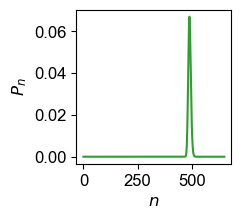

(489.85702987424685 + 0.0im, 6.001284308664551 + 0.0im, 0.07352229560259453 + 0.0im)

In [81]:
kk = 1;
ρss = abs.(reshape(minval[2][:,kk],((N_cutoff+1)*(N_d+1)*N_gain,(N_cutoff+1)*(N_d+1)*N_gain)))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b,ρss);

ρ_ph_ad = ptrace(ρ_op,3);
ρ_ph_a = ptrace(ρ_op,[2,3]);
ρ_ph_d = ptrace(ρ_op,[1,3]);
ρ_at = ptrace(ρ_op,[1,2]);

figure(figsize=(2,2));
plot(diag(ρ_ph_a.data),linestyle="-",color="C2")
xlabel(L"n")
ylabel(L"P_n")
stats(nvals_a,diag(ρ_ph_a.data))

Finally, here's one more example with a two-level gain medium that gives an uncertainty of basically 1 on 60 photons. 

In [78]:
b_emit = SpinBasis(1//2);

N_cutoff = 100;
N_d = 2;

nvals_a = [0:1:N_cutoff;];
nvals_d = [0:1:N_d;];

b_fock = FockBasis(N_cutoff);
b_d = FockBasis(N_d);

b = b_emit ⊗ b_fock ⊗ b_d;

σxe = sigmax(b_emit);
σye = sigmay(b_emit);
σze = sigmaz(b_emit);
σpe = sigmap(b_emit);
σme = sigmam(b_emit);
Ie = identityoperator(b_emit);

a = destroy(b_fock);
ad = create(b_fock);
n = number(b_fock);
Ip = identityoperator(b_fock);

d = destroy(b_d);
dd = create(b_d);
nd = number(b_d);
Id = identityoperator(b_d);

ωc = 1.0;
δ = 10e-3;
ωd = 1 + δ;

β = 1.5e-4;
λ = 1e-6;
κd = 1e-4;
κa = (1e-10)*exp(0*1im*pi);

ϵ = 1e-6;
ωe = 1.0;

H_nl =  ωc*n + 0.5*β*n^2;

H_rwa =  Ie ⊗ H_nl ⊗ Id + ωe/2*(σze ⊗ Ip ⊗ Id) + ϵ*(σpe ⊗ a ⊗ Id + σme ⊗ ad ⊗ Id) +
         λ*(Ie ⊗ a ⊗ dd + Ie ⊗ ad ⊗ d) + ωd*(Ie ⊗ Ip ⊗ nd);

H_rwa_sp = H_rwa;

Γ = 1e-3;

r = 4*Γ;

jump_r = σpe ⊗ Ip ⊗ Id;
jump_Γ = σme ⊗ Ip ⊗ Id;
jump_γ = Ie ⊗ (sqrt(Complex(κd))*(Ip ⊗ d) + sqrt(Complex(κa))*(a ⊗ Id));

jumps_sp = [jump_r, jump_Γ, jump_γ];
rates_sp = [r, Γ, 1];

liouville_op = liouvillian(H_rwa_sp, jumps_sp; rates=rates_sp);
liouville_mat = sparse(liouville_op).data;
droptol!(liouville_mat,abs(κa)/1000);

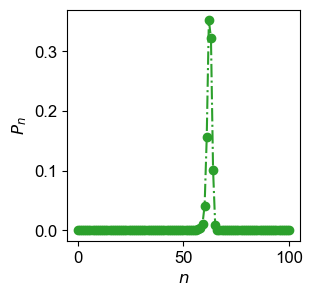

(62.24451661275244 + 0.0im, 1.2200522051597458 + 0.0im, 0.023914192997527336 + 0.0im)

In [79]:
@elapsed minval = eigs(liouville_mat,nev = 1, which=:SM)

kk = 1;
ρss = abs.(reshape(minval[2][:,kk],(2*(N_cutoff+1)*(N_d+1),2*(N_cutoff+1)*(N_d+1))))
ρss = ρss/tr(ρss);

ρ_op = DenseOperator(b,ρss);

ρ_ph_ad = ptrace(ρ_op,1);
ρ_ph_a = ptrace(ptrace(ρ_op,1),2);
ρ_ph_d = ptrace(ptrace(ρ_op,1),1);
ρ_at = ptrace(ptrace(ρ_op,3),2);

figure(figsize=(3,3));
plot(diag(ρ_ph_a.data),linestyle="-.",marker="o",color="C2")
xlabel(L"n")
ylabel(L"P_n")

stats(nvals_a,diag(ρ_ph_a.data))